# **Image Denoising Application**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Preprocessing**

In [2]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from keras.callbacks import EarlyStopping

In [ ]:
high_res_path = '/content/drive/MyDrive/Colab Notebooks/Train/Train/high'
low_res_path = '/content/drive/MyDrive/Colab Notebooks/Train/Train/low'

high_res_images = [os.path.join(high_res_path, f) for f in os.listdir(high_res_path) if f.endswith(('png', 'jpg', 'jpeg','bmp'))]
low_res_images = [os.path.join(low_res_path, f) for f in os.listdir(low_res_path) if f.endswith(('png', 'jpg', 'jpeg','bmp'))]

# Somehow the images were randomly shuffled such that same indeces in different list didn't store same image
high_res_images.sort()
low_res_images.sort()

# To confirm they are sortes now
# for i in range(485):
#     print(high_res_images[i].split('/')[-1]," ",low_res_images[i].split('/')[-1])
# Confirmed. No need to print now

# To get better model output, I am going to increase the dataset
# For this I can divide the image into patches
# But since images are alredy about 600x400 pixels, dividing and then resizing might compromise with the quality
# Instead I would mirror the image about X, Y and X+Y combined, resulting in 4 variations of each image

def horizontal_flip(image):
    return image[:, ::-1]

def vertical_flip(image):
    return image[::-1, :]

def augment_img(file):
    aug=[]
    img = Image.open(file)
    img = img.resize((256,256))
    img = np.array(img)
    aug.append(img)
    aug.append(horizontal_flip(img))
    aug.append(vertical_flip(horizontal_flip(img)))
    aug.append(vertical_flip(horizontal_flip(img)))
    return aug

X = []
for low in low_res_images:
    X.extend(augment_img(low))
y = []
for high in high_res_images:
    y.extend(augment_img(high))

X = np.array(X)
y = np.array(y)

#Normalise the images
X = X.astype('float32') / 255.0
y = y.astype('float32') / 255.0

print(f"Loaded {X.shape[0]} low res images of res {X.shape[1]},{X.shape[2]}")
print(f"Loaded {y.shape[0]} high res images of res {y.shape[1]},{y.shape[2]}")

In [ ]:
# Reviewing the dataset sample
index = np.random.randint(0, len(X))
fig, axes = plt.subplots(1, 2)
axes[0].imshow(X[index])
axes[0].set_title('Noise')
axes[1].imshow(y[index])
axes[1].set_title('Original')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Confirming the split
print(f"Train set: {X_train.shape[0]} images of resolution {X_train.shape[1]}x{X_train.shape[2]}")
print(f"Test set: {X_test.shape[0]} images of resolution {X_test.shape[1]}x{X_test.shape[2]}")

In [ ]:
# Defining a EarlyStopping callback to avoid overfitting if any
# Will be used in training models later
callback = EarlyStopping(monitor='loss',
                         patience=5,
                         min_delta = 0.0001,
                         mode = "auto",
                         baseline = None,
                         restore_best_weights = False)

### **Understanding the Performance Metric**
As per the problem statement, the results are to be judged by **Peak Signal to Noise Ratio (PSNR)**.

It is defined (in dB) as:

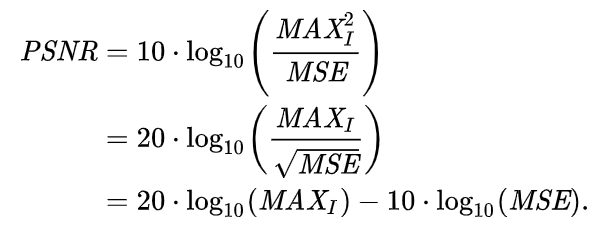

where MAX is maximum piscel value of original image and MSE is mean square error.

I am going to use pre defined psnr function of Tensorflow.image

## **Defining Models**

### **1. Auto Encoder**
This is a simple encoder-decoder network with 3 convolutional layers followed by max-pooling for the encoder unit and 3 deconvolutional layers for the decoder unit. The output from the decoder is then given to a convolutional layer with 3 filters to maintain similar input and output shape.

In [ ]:
model1 = keras.Sequential([
    # Encoding
    keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same", input_shape=(256, 256, 3)),
    keras.layers.MaxPooling2D((2, 2), padding="same"),
    keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same"),
    keras.layers.MaxPooling2D((2, 2), padding="same"),
    keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding="same"),
    keras.layers.MaxPooling2D((2, 2), padding="same"),

    # Decoding
    keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal', activation='relu'),
    keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal', activation='relu'),
    keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', kernel_initializer='he_normal', activation='relu'),
    keras.layers.Conv2D(3, (3, 3), activation='sigmoid', kernel_initializer='he_normal', padding="same"),
])

model1.compile(optimizer='adam', loss='mse')
model1.summary()

In [ ]:
# Training the auto encoder model
history1 = model1.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test,y_test), callbacks=callback)
history1

Epoch 1/20
97/97 [==============================] - 661s 7s/step - loss: 0.0354 - val_loss: 0.0311
Epoch 2/20
97/97 [==============================] - 617s 6s/step - loss: 0.0267 - val_loss: 0.0282
Epoch 3/20
97/97 [==============================] - 614s 6s/step - loss: 0.0255 - val_loss: 0.0243
Epoch 4/20
97/97 [==============================] - 615s 6s/step - loss: 0.0248 - val_loss: 0.0243
Epoch 5/20
97/97 [==============================] - 653s 7s/step - loss: 0.0235 - val_loss: 0.0241
Epoch 6/20
41/97 [===========>..................] - ETA: 5:30 - loss: 0.0228

In [ ]:
# Visualising the results
index = np.random.randint(0, len(X))
fig, axes = plt.subplots(1, 3)
axes[0].imshow(X[index])
axes[0].set_title('Noise')
axes[1].imshow(model1.predict(X[index].reshape(1, 256, 256, 3))[0])
axes[1].set_title('De-noised')
axes[2].imshow(y[index])
axes[2].set_title('Original')
plt.show()

In [ ]:
# Calculating PSNR value
PSNR1 = 0
for i in range(len(X)):
    pred = model1.predict(X[i].reshape(1,256,256,3))
    m = np.mean((y[i]-pred)**2)
    PSNR1 += 10*np.log10(1/m)

PSNR1 = PSNR1 / len(X)
print(f"PSNR of Auto-Encoder model: {PSNR1}")

PSNR of Auto-Encoder model: 21.166486749173718

This model was trained with 20 Epochs and batch size 16.

In [ ]:
# Saving weights
model1.save_weights('/content/drive/MyDrive/Colab Notebooks/ImageDenoisWeights/model1.h5')

### **2. Convolutional Blind Denoising Network (CBDNet)**
The CBDNet architecture comes with 2 subnetworks. First is a noise estimation subnetwork (CNNe- estimates the noise level map in a noisy image), followed by a non-blind denoising subnetwork (CNNd- denoises the noisy image).

In [ ]:
input = keras.Input(shape=(256, 256, 3))

#Noise estimation subnetwork
x = keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(input)
x = keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
x = keras.layers.Conv2D(3, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)

#Non Blind denoising subnetwork
x = keras.layers.concatenate([x,input])
conv1 = keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(x)
conv2 = keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv1)

pool1 = keras.layers.AveragePooling2D(pool_size=(2,2),padding='same')(conv2)
conv3 = keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(pool1)
conv4 = keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv3)
conv5 = keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv4)

pool2 = keras.layers.AveragePooling2D(pool_size=(2,2),padding='same')(conv5)
conv6 = keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(pool2)
conv7 = keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv6)
conv8 = keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv7)
conv9 = keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv8)
conv10 = keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv9)
conv11 = keras.layers.Conv2D(256, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv10)

upsample1 = keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv11)
add1 = keras.layers.Add()([upsample1,conv5])
conv12 = keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(add1)
conv13 = keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv12)
conv14 = keras.layers.Conv2D(128, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv13)

upsample2 = keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv14)
add1 = keras.layers.Add()([upsample2,conv2])
conv15 = keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(add1)
conv16 = keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer='he_normal',padding="same")(conv15)

out = keras.layers.Conv2D(3, (1,1), kernel_initializer='he_normal',padding="same")(conv16)
out = keras.layers.Add()([out,input])

model2 = keras.Model(input,out)
model2.compile(optimizer='adam', loss='mse')
model2.summary()

In [ ]:
# Training CBDNet Model
history2 = model2.fit(X_train, y_train, epochs=5, batch_size=8, validation_data=(X_test,y_test), callbacks=callback)
history2

In [ ]:
# Visualising the results
index = np.random.randint(0, len(X))
fig, axes = plt.subplots(1, 3)
axes[0].imshow(X[index])
axes[0].set_title('Noise')
axes[1].imshow(model2.predict(X[index].reshape(1, 256, 256, 3))[0])
axes[1].set_title('De-noised')
axes[2].imshow(y[index])
axes[2].set_title('Original')
plt.show()

In [ ]:
# Calculating PSNR value
PSNR2 = 0
for i in range(len(X_test)):
    pred = model1.predict(X[i].reshape(1,256,256,3))
    m = np.mean((y[i]-pred)**2)
    PSNR2 += 10*np.log10(1/m)

PSNR2 = PSNR2 / len(X_test)
print(f"PSNR of CBDNet model: {PSNR2}")

In [ ]:
# Saving the weights
model2.save_weights('/content/drive/MyDrive/Colab Notebooks/ImageDenoisWeights/model2.h5')

### **3. Residual Image Denoising Network (RIDNet)**
This network is composed of three main modules as follows :



1.   **Feature Extraction Module**:
It is composed of only one convolutional layer to extract initial features from the noisy input. I’ve used 64 filters with kernel size=3 for the convolutional layer.
2.   **Feature Learning Residual on Residual Module**: It is composed of a network called Enhancement Attention Modules (EAM) that uses a residual on the residual structure with local skip and short skip connections. The initial part of EAM uses wide receptive fields through kernel dilation and branched convolutions thereby capturing global and diverse information from the input image. Additional features are learned using a residual block of two convolutions followed by an enhanced residual block (ERB) of three convolutions. Finally, it is given to a feature attention block that gives more weight to the important features.

3.   **Reconstruction Module**: The output of the final EAM block is given to the reconstruction module which is again composed of only one convolutional layer that gives the denoised image as output.

In [10]:
class EAM(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

        self.conv1 = keras.layers.Conv2D(64, (3,3), dilation_rate=1,padding='same',activation='relu')
        self.conv2 = keras.layers.Conv2D(64, (3,3), dilation_rate=2,padding='same',activation='relu')

        self.conv3 = keras.layers.Conv2D(64, (3,3), dilation_rate=3,padding='same',activation='relu')
        self.conv4 = keras.layers.Conv2D(64, (3,3), dilation_rate=4,padding='same',activation='relu')

        self.conv5 = keras.layers.Conv2D(64, (3,3),padding='same',activation='relu')

        self.conv6 = keras.layers.Conv2D(64, (3,3),padding='same',activation='relu')
        self.conv7 = keras.layers.Conv2D(64, (3,3),padding='same')

        self.conv8 = keras.layers.Conv2D(64, (3,3),padding='same',activation='relu')
        self.conv9 = keras.layers.Conv2D(64, (3,3),padding='same',activation='relu')
        self.conv10 = keras.layers.Conv2D(64, (1,1),padding='same')

        self.gap = keras.layers.GlobalAveragePooling2D()

        self.conv11 = keras.layers.Conv2D(64, (3,3),padding='same',activation='relu')
        self.conv12 = keras.layers.Conv2D(64, (3,3),padding='same',activation='sigmoid')

    def call(self,input):
        conv1 = self.conv1(input)
        conv1 = self.conv2(conv1)

        conv2 = self.conv3(input)
        conv2 = self.conv4(conv2)

        concat = keras.layers.concatenate([conv1,conv2])
        conv3 = self.conv5(concat)
        add1 = keras.layers.Add()([input,conv3])

        conv4 = self.conv6(add1)
        conv4 = self.conv7(conv4)
        add2 = keras.layers.Add()([conv4,add1])
        add2 = keras.layers.Activation('relu')(add2)

        conv5 = self.conv8(add2)
        conv5 = self.conv9(conv5)
        conv5 = self.conv10(conv5)
        add3 = keras.layers.Add()([add2,conv5])
        add3 = keras.layers.Activation('relu')(add3)

        gap = self.gap(add3)
        gap = keras.layers.Reshape((1,1,64))(gap)
        conv6 = self.conv11(gap)
        conv6 = self.conv12(conv6)

        mul = keras.layers.Multiply()([conv6, add3])
        out = keras.layers.Add()([input,mul])
        return out

# Ensure the layer can be serialized and deserialized for saving/loading models
tf.keras.utils.get_custom_objects().update({'EAM': EAM})

In [11]:
model3 = tf.keras.Sequential()
model3.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model3.add(EAM())
model3.add(EAM())
model3.add(EAM())
model3.add(keras.layers.Conv2D(3, (3, 3), padding='same', activation='sigmoid'))

model3.compile(optimizer='adam', loss='mean_squared_error')
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 eam (EAM)                   (None, 256, 256, 64)      447232    
                                                                 
 eam_1 (EAM)                 (None, 256, 256, 64)      447232    
                                                                 
 eam_2 (EAM)                 (None, 256, 256, 64)      447232    
                                                                 
 conv2d_59 (Conv2D)          (None, 256, 256, 3)       1731      
                                                                 
Total params: 1345219 (5.13 MB)
Trainable params: 1345219 (5.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training the RIDNet model
history3 = model3.fit(X_train, y_train, epochs=5, batch_size=8,validation_data=(X_test,y_test),callbacks=callback)
history3

In [ ]:
# Visualising the results
index = np.random.randint(0, len(X))
fig, axes = plt.subplots(1, 3)
axes[0].imshow(X[index])
axes[0].set_title('Noise')
axes[1].imshow(model3.predict(X[index].reshape(1, 256, 256, 3))[0])
axes[1].set_title('De-noised')
axes[2].imshow(y[index])
axes[2].set_title('Original')
plt.show()

In [ ]:
# Calculating PSNR value
PSNR3 = 0
for i in range(len(X_test)):
    pred = model3.predict(X[i].reshape(1,256,256,3))
    m = np.mean((y[i]-pred)**2)
    PSNR3 += 5*np.log10(255/m)

PSNR3 = PSNR3 / len(X_test)
print(f"PSNR of RIDNet model: {PSNR3}")

In [ ]:
# Saving the weights
model3.save_weights('/content/drive/MyDrive/Colab Notebooks/ImageDenoisWeights/model3.h5')

### **Deep Curve Estimation Network (DCENet)**

Deep Curve Estimation (DCE) networks are a type of deep learning model made for tasks like enhancing images in low light. Unlike traditional methods that make uniform changes, DCE networks learn to make context-specific adjustments by estimating curves that change pixel values dynamically.

Key Features of Zero-DCE:



1.   **Image-Specific Adjustments:** Zero-DCE uses a deep network to create curves tailored to each image for adjusting the dynamic range. These curves allow for detailed and localized enhancements.
2.   **No Reference Images Needed:** It doesn’t need any paired or unpaired reference images during training. This is done using special loss functions that evaluate enhancement quality without references.
3.    **Dynamic Range Enhancement:** The curves adjust input pixel values to enhance brightness and contrast effectively across a wide dynamic range.

In [ ]:
class DCEModel(keras.Model):
    def __init__(self, **kwargs):
        super(DCEModel, self).__init__(**kwargs)
        self.enhancement_network = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super(DCEModel, self).compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_consistency_loss = SpatialConsistencyLoss(reduction="none")

    def apply_enhancement(self, input_image, enhancement_factors):
        """Apply enhancement factors progressively to the input image."""
        layer_1 = enhancement_factors[:, :, :, :3]
        layer_2 = enhancement_factors[:, :, :, 3:6]
        layer_3 = enhancement_factors[:, :, :, 6:9]
        layer_4 = enhancement_factors[:, :, :, 9:12]
        layer_5 = enhancement_factors[:, :, :, 12:15]
        layer_6 = enhancement_factors[:, :, :, 15:18]
        layer_7 = enhancement_factors[:, :, :, 18:21]
        layer_8 = enhancement_factors[:, :, :, 21:24]

        enhanced_image = input_image + layer_1 * (tf.square(input_image) - input_image)
        enhanced_image = enhanced_image + layer_2 * (tf.square(enhanced_image) - enhanced_image)
        enhanced_image = enhanced_image + layer_3 * (tf.square(enhanced_image) - enhanced_image)
        enhanced_image = enhanced_image + layer_4 * (tf.square(enhanced_image) - enhanced_image)
        enhanced_image = enhanced_image + layer_5 * (tf.square(enhanced_image) - enhanced_image)
        enhanced_image = enhanced_image + layer_6 * (tf.square(enhanced_image) - enhanced_image)
        enhanced_image = enhanced_image + layer_7 * (tf.square(enhanced_image) - enhanced_image)
        final_image = enhanced_image + layer_8 * (tf.square(enhanced_image) - enhanced_image)

        return final_image

    def call(self, inputs):
        enhancement_params = self.enhancement_network(inputs)
        return self.apply_enhancement(inputs, enhancement_params)

    def compute_loss_components(self, original_image, enhancement_params):
        enhanced_image = self.apply_enhancement(original_image, enhancement_params)
        illumination_smoothness_loss_value = 200 * illumination_smoothness_loss(enhancement_params)
        spatial_consistency_loss_value = tf.reduce_mean(self.spatial_consistency_loss(enhanced_image, original_image))
        color_consistency_loss_value = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        exposure_loss_value = 10 * tf.reduce_mean(exposure_loss(enhanced_image))

        total_loss = (
            illumination_smoothness_loss_value
            + spatial_consistency_loss_value
            + color_consistency_loss_value
            + exposure_loss_value
        )

        return {
            "total_loss": total_loss,
            "illumination_loss": illumination_smoothness_loss_value,
            "spatial_loss": spatial_consistency_loss_value,
            "color_loss": color_consistency_loss_value,
            "exposure_loss": exposure_loss_value,
        }

    def train_step(self, batch_data):
        with tf.GradientTape() as tape:
            enhancement_outputs = self.enhancement_network(batch_data)
            loss_values = self.compute_loss_components(batch_data, enhancement_outputs)

        gradients = tape.gradient(loss_values["total_loss"], self.enhancement_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.enhancement_network.trainable_variables))

        return loss_values

    def test_step(self, batch_data):
        enhancement_outputs = self.enhancement_network(batch_data)
        return self.compute_loss_components(batch_data, enhancement_outputs)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        """Save weights for the enhancement network."""
        self.enhancement_network.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        """Load weights into the enhancement network."""
        self.enhancement_network.load_weights(
            filepath=filepath, by_name=by_name, skip_mismatch=skip_mismatch, options=options
        )


In [ ]:
model4 = CustomDCE()
model.compile(learning_rate=1e-2, metrics=['accuracy'])
training_history = model4.fit(training_data, validation_data=validation_data, epochs=20)

In [ ]:
PSNR4 = 0
for i in range(len(X_test)):
    pred = model4.predict(X[i].reshape(1,256,256,3))
    m = np.mean((y[i]-pred)**2)
    PSNR3 += 5*np.log10(255/m)

PSNR4 = PSNR4 / len(X_test)
print(f"PSNR of DCENet model: {PSNR4}")

In [ ]:
# Saving the weights
model4.save_weights('/content/drive/MyDrive/Colab Notebooks/ImageDenoisWeights/model4.h5')